In [1]:
import os
import cv2
import configparser
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow import keras
print(tf.__version__)

2023-11-18 13:10:09.691616: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1


2.3.0


In [2]:
root_path = "./translations"

In [3]:
# Train on MNIST
exp_path = "./train_on_mnist"
os.makedirs(exp_path, exist_ok=True)
train_path = root_path + "/mnist2mnist"
test_path = root_path + "/svhn2svhn"
model_save_path = exp_path + "/resnet50_mnist_svhn_model.hdf5"

In [3]:
# Train on MNIST-to-SVHN
exp_path = "./train_on_mnist2svhn"
os.makedirs(exp_path, exist_ok=True)
train_path = root_path + "/mnist2svhn"
test_path = root_path + "/svhn2svhn"
model_save_path = exp_path + "/resnet50_mnist2svhn_svhn_model.hdf5"

In [4]:
# load data into a list of nparray
x_train = []
train_y = []
for folder in sorted(os.listdir(train_path)):
    folder_path = os.path.join(train_path,folder)
    for img_name in os.listdir(folder_path)[:5000]:
        img_path = os.path.join(folder_path,img_name)
        img = cv2.imread(img_path)
        x_train.append(img)
        train_y.append(int(folder))
        
x_test = []
test_y = []
for folder in sorted(os.listdir(test_path)):
    folder_path = os.path.join(test_path,folder)
    for img_name in os.listdir(folder_path)[:2000]:
        img_path = os.path.join(folder_path,img_name)
        img = cv2.imread(img_path)
        x_test.append(img)
        test_y.append(int(folder))
        
x_val = []
val_y = []
for folder in sorted(os.listdir(train_path)):
    folder_path = os.path.join(train_path,folder)
    for img_name in os.listdir(folder_path)[5000:]:
        img_path = os.path.join(folder_path,img_name)
        img = cv2.imread(img_path)
        x_val.append(img)   
        val_y.append(int(folder))

In [5]:
# convert to array
x_train = np.array(x_train)
x_test = np.array(x_test)
x_val = np.array(x_val)
x_train = x_train/255.0
x_test = x_test/255.0
x_val = x_val/255.0
train_y = np.array(train_y)
test_y = np.array(test_y)
val_y = np.array(val_y)

In [6]:
x_train.shape, x_test.shape, x_val.shape, train_y.shape, test_y.shape, val_y.shape

((50000, 32, 32, 3),
 (20000, 32, 32, 3),
 (10000, 32, 32, 3),
 (50000,),
 (20000,),
 (10000,))

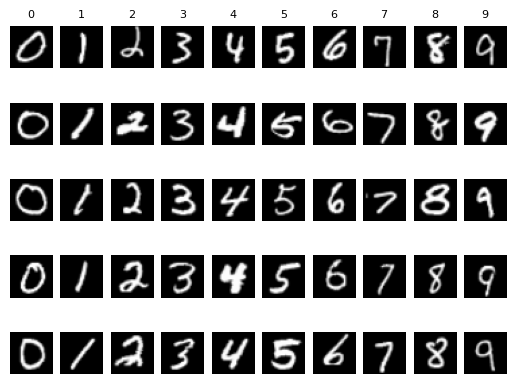

In [7]:
# Show MNIST training data
num_classes = 10
samples_per_class = 5

for class_index in range(num_classes):
    indices = np.flatnonzero(train_y == class_index)
    indices = np.random.choice(indices, samples_per_class, replace=False)
    
    for sample_i, index in enumerate(indices):
        plt_idx = sample_i * num_classes + class_index + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(x_train[index])
        plt.axis('off')
        if sample_i == 0:
            plt.title(class_index, fontsize = 8)

plt.show()

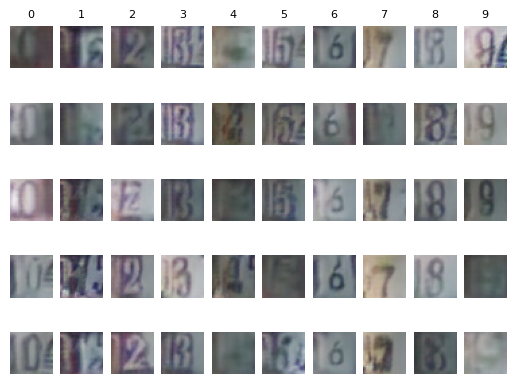

In [7]:
# Show MNIST-to-SVHN training data
num_classes = 10
samples_per_class = 5

for class_index in range(num_classes):
    indices = np.flatnonzero(train_y == class_index)
    indices = np.random.choice(indices, samples_per_class, replace=False)
    
    for sample_i, index in enumerate(indices):
        plt_idx = sample_i * num_classes + class_index + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(x_train[index])
        plt.axis('off')
        if sample_i == 0:
            plt.title(class_index, fontsize = 8)

plt.show()

In [8]:
from tensorflow.keras import layers
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [9]:
IMG_SIZE=32
NUM_CLASSES=10

In [10]:
# ResNet
def build_model(num_classes, img_size):
    
    resnet = ResNet50(input_shape=(img_size, img_size, 3), weights='imagenet', include_top=False)
    
    #do not train the pre-trained layers of ResNet50
    for layer in resnet.layers:
        layer.trainable = False
        
    x = layers.GlobalAveragePooling2D()(resnet.output)
    prediction = layers.Dense(num_classes, activation='softmax', name="pred")(x)

    model = tf.keras.Model(inputs=resnet.input, outputs=prediction, name="ResNet")

    return model

In [11]:
model = build_model(num_classes=NUM_CLASSES,img_size=IMG_SIZE)
print(model.summary())

2023-11-18 13:12:52.181295: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcuda.so.1
2023-11-18 13:12:52.347436: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1716] Found device 0 with properties: 
pciBusID: 0000:12:00.0 name: Tesla T4 computeCapability: 7.5
coreClock: 1.59GHz coreCount: 40 deviceMemorySize: 14.56GiB deviceMemoryBandwidth: 298.08GiB/s
2023-11-18 13:12:52.347479: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
2023-11-18 13:12:52.380145: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcublas.so.10
2023-11-18 13:12:52.405377: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcufft.so.10
2023-11-18 13:12:52.414001: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcurand.so.10
2023-11-

Model: "ResNet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 38, 38, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 16, 16, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 16, 16, 64)   256         conv1_conv[0][0]                 
_____________________________________________________________________________________________

In [12]:
batch_size = 64
loss = 'sparse_categorical_crossentropy'
num_epochs = 100
optim = "adam"
early_stop = EarlyStopping(monitor='val_loss',mode='min',verbose=1,patience=50,restore_best_weights=True)
rlronp=tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=5, verbose=1, min_lr=0.000001)

model.compile(
      loss=loss,
      optimizer=optim,
      metrics=['sparse_categorical_accuracy']
    )

In [13]:
hist=model.fit(
    x=x_train,y=train_y, 
    epochs=num_epochs, 
    batch_size=batch_size, 
    validation_data=(x_val, val_y),
    verbose=1, 
    callbacks=[early_stop,rlronp], 
    shuffle=True)
model.save(model_save_path)

# summarize history for accuracy
plt.plot(hist.history['sparse_categorical_accuracy'])
plt.plot(hist.history['val_sparse_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.savefig(f'{exp_path}/accuracy.png')
plt.close()
# summarize history for loss
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.savefig(f'{exp_path}/loss.png')
plt.close()

model.evaluate(x_test, test_y, batch_size=32)

Epoch 1/100


2023-11-18 13:13:16.172301: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcublas.so.10
2023-11-18 13:13:16.890575: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudnn.so.7


782/782 [==============================] - 10s 13ms/step - loss: 2.0364 - sparse_categorical_accuracy: 0.3106 - val_loss: 1.6780 - val_sparse_categorical_accuracy: 0.4943
Epoch 2/100
782/782 [==============================] - 9s 12ms/step - loss: 1.6828 - sparse_categorical_accuracy: 0.4737 - val_loss: 1.4327 - val_sparse_categorical_accuracy: 0.5946
Epoch 3/100
782/782 [==============================] - 9s 12ms/step - loss: 1.5026 - sparse_categorical_accuracy: 0.5432 - val_loss: 1.2609 - val_sparse_categorical_accuracy: 0.6693
Epoch 4/100
782/782 [==============================] - 9s 12ms/step - loss: 1.3866 - sparse_categorical_accuracy: 0.5807 - val_loss: 1.2147 - val_sparse_categorical_accuracy: 0.6556
Epoch 5/100
782/782 [==============================] - 9s 12ms/step - loss: 1.2994 - sparse_categorical_accuracy: 0.6142 - val_loss: 1.1267 - val_sparse_categorical_accuracy: 0.7172
Epoch 6/100
782/782 [==============================] - 9s 12ms/step - loss: 1.2331 - sparse_categoric

Epoch 46/100
782/782 [==============================] - 9s 12ms/step - loss: 0.6862 - sparse_categorical_accuracy: 0.7960 - val_loss: 0.5933 - val_sparse_categorical_accuracy: 0.8365
Epoch 47/100
782/782 [==============================] - 10s 12ms/step - loss: 0.6839 - sparse_categorical_accuracy: 0.7971 - val_loss: 0.5716 - val_sparse_categorical_accuracy: 0.8466
Epoch 48/100
782/782 [==============================] - 9s 12ms/step - loss: 0.6796 - sparse_categorical_accuracy: 0.7986 - val_loss: 0.5770 - val_sparse_categorical_accuracy: 0.8400
Epoch 49/100
782/782 [==============================] - 9s 12ms/step - loss: 0.6767 - sparse_categorical_accuracy: 0.7984 - val_loss: 0.5810 - val_sparse_categorical_accuracy: 0.8374
Epoch 50/100
782/782 [==============================] - 10s 12ms/step - loss: 0.6736 - sparse_categorical_accuracy: 0.7995 - val_loss: 0.5645 - val_sparse_categorical_accuracy: 0.8463
Epoch 51/100
782/782 [==============================] - 10s 12ms/step - loss: 0.669

Epoch 90/100
782/782 [==============================] - 9s 12ms/step - loss: 0.5938 - sparse_categorical_accuracy: 0.8275 - val_loss: 0.5069 - val_sparse_categorical_accuracy: 0.8630
Epoch 91/100
782/782 [==============================] - 9s 12ms/step - loss: 0.5911 - sparse_categorical_accuracy: 0.8276 - val_loss: 0.5083 - val_sparse_categorical_accuracy: 0.8608
Epoch 92/100
782/782 [==============================] - 9s 12ms/step - loss: 0.5900 - sparse_categorical_accuracy: 0.8284 - val_loss: 0.5134 - val_sparse_categorical_accuracy: 0.8595
Epoch 93/100
782/782 [==============================] - 9s 12ms/step - loss: 0.5900 - sparse_categorical_accuracy: 0.8285 - val_loss: 0.5162 - val_sparse_categorical_accuracy: 0.8605
Epoch 94/100
780/782 [============================>.] - ETA: 0s - loss: 0.5893 - sparse_categorical_accuracy: 0.8282
Epoch 00094: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
782/782 [==============================] - 9s 12ms/step - loss: 0.5894 

[5.2815446853637695, 0.19335000216960907]

In [14]:
# Test model trained on MNIST
hdf5_model = "./train_on_mnist/resnet50_mnist_svhn_model.hdf5"
loaded_model_from_hdf5 = tf.keras.models.load_model(hdf5_model)
loaded_model_from_hdf5.evaluate(x_test, test_y, batch_size=1)

20000/20000 [==============================] - 112s 6ms/step - loss: 5.8103 - sparse_categorical_accuracy: 0.1130


[5.810309886932373, 0.11304999887943268]

In [15]:
# Test model trained on MNIST-to-SVHN
hdf5_model = "./train_on_mnist2svhn/resnet50_mnist2svhn_svhn_model.hdf5"
loaded_model_from_hdf5 = tf.keras.models.load_model(hdf5_model)
loaded_model_from_hdf5.evaluate(x_test, test_y, batch_size=1)

20000/20000 [==============================] - 112s 6ms/step - loss: 5.2816 - sparse_categorical_accuracy: 0.1934


[5.281564235687256, 0.19335000216960907]